In [33]:
import os
import re
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score
from sklearn.decomposition import PCA
DATA_DIR = "data"
RESULTS_DIR = "results"
os.makedirs(RESULTS_DIR, exist_ok=True)

TRAIN_FASTA = os.path.join(DATA_DIR, "/content/train_sequences.fasta")
TRAIN_TERMS = os.path.join(DATA_DIR, "/content/train_terms.tsv")
TEST_FASTA  = os.path.join(DATA_DIR, "/content/testsuperset.fasta")
ASPECT = "F"
TOP_N_GO = 100
RANDOM_SEED = 42

In [34]:
AMINO_ACIDS = ["A","C","D","E","F","G","H","I","K","L",
               "M","N","P","Q","R","S","T","V","W","Y"]

AA_SET = set(AMINO_ACIDS)

def read_fasta(path):

    sequences = {}
    current_id = None
    current_seq = []

    with open(path, "r") as file:
        for line in file:
            line = line.strip()

            if line.startswith(">"):
                if current_id is not None:
                    sequences[current_id] = "".join(current_seq)

                header = line[1:].split()[0]
                if "|" in header:
                    current_id = header.split("|")[1]
                else:
                    current_id = header

                current_seq = []

            else:
                current_seq.append(line)


        if current_id is not None:
            sequences[current_id] = "".join(current_seq)

    return sequences


def clean_sequence(sequence):

    sequence = sequence.upper()
    sequence = re.sub(r"[^A-Z]", "", sequence)

    clean_seq = ""
    for aa in sequence:
        if aa in AA_SET:
            clean_seq += aa

    return clean_seq


def clean_fasta(sequences_dict):

    cleaned_sequences = {}
    removed_count = 0

    for pid, seq in sequences_dict.items():
        seq_clean = clean_sequence(seq)

        if len(seq_clean) == 0:
            removed_count += 1
        else:
            cleaned_sequences[pid] = seq_clean

    print("Séquences supprimées après nettoyage :", removed_count)
    return cleaned_sequences


train_sequences_raw = read_fasta(TRAIN_FASTA)
test_sequences_raw  = read_fasta(TEST_FASTA)

train_sequences = clean_fasta(train_sequences_raw)
test_sequences  = clean_fasta(test_sequences_raw)

print("Nombre de séquences d'entraînement :", len(train_sequences))
print("Nombre de séquences de test :", len(test_sequences))


Séquences supprimées après nettoyage : 0
Séquences supprimées après nettoyage : 0
Nombre de séquences d'entraînement : 82404
Nombre de séquences de test : 224309


In [35]:

terms_df = pd.read_csv(TRAIN_TERMS, sep="\t")

terms_df = terms_df.rename(columns={
    "EntryID": "protein_id",
    "term": "go_id"
})

terms_df = terms_df[terms_df["aspect"] == ASPECT]

print("Nombre d'annotations après filtre sur l'aspect :", len(terms_df))
print("Aspect présent :", terms_df["aspect"].unique())
go_counts = terms_df["go_id"].value_counts()
top_go = go_counts.head(TOP_N_GO).index.tolist()
terms_df = terms_df[terms_df["go_id"].isin(top_go)]

print("Nombre de termes GO conservés :", len(top_go))
print("Nombre d'annotations finales :", len(terms_df))


Nombre d'annotations après filtre sur l'aspect : 128452
Aspect présent : ['F']
Nombre de termes GO conservés : 100
Nombre d'annotations finales : 74283


In [14]:

protein_to_go = terms_df.groupby("protein_id")["go_id"].apply(list)
protein_ids = []

for pid in protein_to_go.index:
    if pid in train_sequences:
        protein_ids.append(pid)

print("Nombre de protéines avec séquence et annotations GO :", len(protein_ids))

if len(protein_ids) == 0:
    raise RuntimeError()

Nombre de protéines avec séquence et annotations GO : 43685


In [15]:

def extract_features(sequence):

    length = len(sequence)
    aa_count = Counter(sequence)

    features = []
    for aa in AMINO_ACIDS:
        features.append(aa_count.get(aa, 0) / length)

    features.append(length)

    return np.array(features)


X_list = []
Y_list = []
for pid in protein_ids:
    X_list.append(extract_features(train_sequences[pid]))

    Y_list.append(protein_to_go[pid])

X = np.array(X_list)
print("Dimensions de X features  :", X.shape)

mlb = MultiLabelBinarizer(classes=top_go)

Y = mlb.fit_transform(Y_list)
print("Dimensions de Y labels:", Y.shape)


Dimensions de X features  : (43685, 21)
Dimensions de Y labels: (43685, 100)


In [16]:
print("Exemple de vecteur de features pour une protéine :")
print("20 fréquences d'acides aminés + la longueur de la séquence")

print(X[0])
print("Nombre total de features par protéine :", X.shape[1])

Exemple de vecteur de features pour une protéine :
20 fréquences d'acides aminés + la longueur de la séquence
[6.07734807e-02 2.20994475e-02 4.41988950e-02 1.04972376e-01
 3.31491713e-02 7.73480663e-02 1.65745856e-02 2.76243094e-02
 7.18232044e-02 8.28729282e-02 1.65745856e-02 3.86740331e-02
 5.52486188e-02 3.86740331e-02 6.62983425e-02 6.07734807e-02
 4.41988950e-02 8.83977901e-02 1.65745856e-02 3.31491713e-02
 1.81000000e+02]
Nombre total de features par protéine : 21


In [17]:
X_train, X_val, Y_train, Y_val = train_test_split(
    X,
    Y,
    test_size=0.2,
    random_state=RANDOM_SEED
)

print("Taille du jeu d'entraînement :", X_train.shape, Y_train.shape)
print("Taille du jeu de validation  :", X_val.shape, Y_val.shape)

Taille du jeu d'entraînement : (34948, 21) (34948, 100)
Taille du jeu de validation  : (8737, 21) (8737, 100)


In [21]:
model_lr = OneVsRestClassifier(
    LogisticRegression(
        max_iter=2000,
        class_weight="balanced"
    )
)

model_lr.fit(X_train, Y_train)

Y_pred_lr = model_lr.predict(X_val)


f1_micro = f1_score(Y_val, Y_pred_lr, average="micro", zero_division=0)
f1_macro = f1_score(Y_val, Y_pred_lr, average="macro", zero_division=0)
precision_micro = precision_score(Y_val, Y_pred_lr, average="micro", zero_division=0)
recall_micro    = recall_score(Y_val, Y_pred_lr, average="micro", zero_division=0)
print("Résultats - Régression logistique")
print("F1 micro :", f1_micro)
print("F1 macro :", f1_macro)
print("Précision micro :", precision_micro)
print("Rappel micro :", recall_micro)

Résultats - Régression logistique
F1 micro : 0.07027529761904762
F1 macro : 0.05060962609986274
Précision micro : 0.03718782113622673
Rappel micro : 0.6373574465213577


In [25]:

model_rf = OneVsRestClassifier(
    RandomForestClassifier(
        n_estimators=50,
        max_depth=15,
        random_state=RANDOM_SEED
    )
)

model_rf.fit(X_train, Y_train)
Y_pred_rf = model_rf.predict(X_val)


f1_micro = f1_score(Y_val, Y_pred_rf, average="micro", zero_division=0)
f1_macro = f1_score(Y_val, Y_pred_rf, average="macro", zero_division=0)
precision_micro = precision_score(Y_val, Y_pred_rf, average="micro", zero_division=0)
recall_micro    = recall_score(Y_val, Y_pred_rf, average="micro", zero_division=0)

print("Résultats - Forêt aléatoire")
print("F1 micro :", f1_micro)
print("F1 macro :", f1_macro)
print("Précision micro :", precision_micro)
print("Rappel micro :", recall_micro)

Résultats - Forêt aléatoire
F1 micro : 0.5829799739703598
F1 macro : 0.052900821849620104
Précision micro : 0.7714444444444445
Rappel micro : 0.46852014305958567


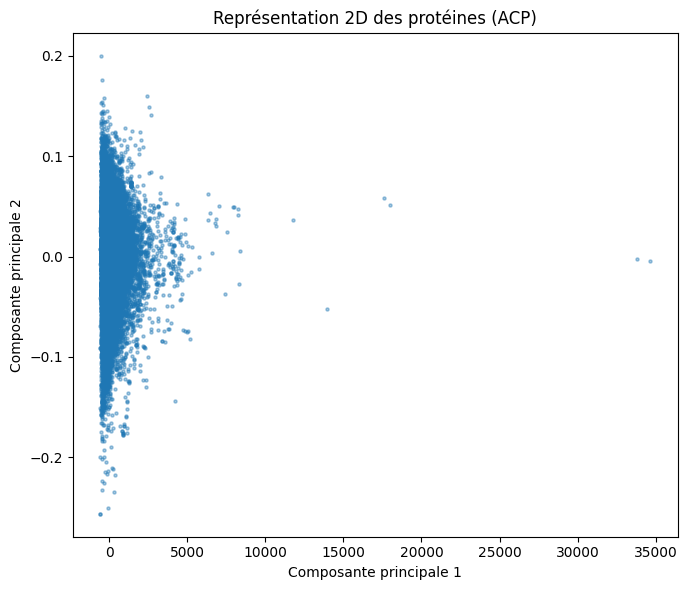

Variance expliquée par PC1 et PC2 : [9.99999972e-01 4.89177647e-09]


In [27]:
pca = PCA(n_components=2, random_state=RANDOM_SEED)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(7, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=5, alpha=0.4)

plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.title("Représentation 2D des protéines (ACP)")

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "pca_proteins.png"), dpi=200)
plt.show()
print("Variance expliquée par PC1 et PC2 :", pca.explained_variance_ratio_)

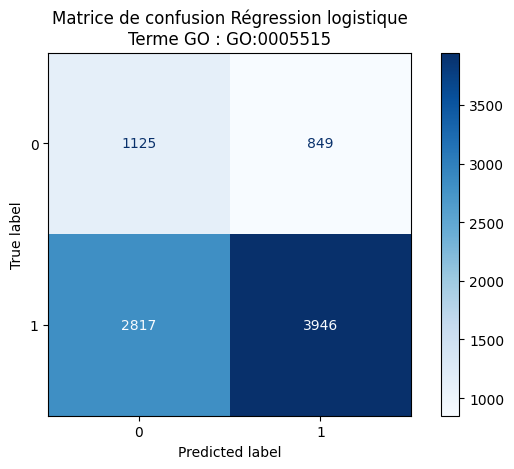

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

go_index = 0
go_name = mlb.classes_[go_index]

cm = confusion_matrix(
    Y_val[:, go_index],
    Y_pred_lr[:, go_index]
)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(
    cmap="Blues",
    values_format="d"
)

plt.title("Matrice de confusion Régression logistique\nTerme GO : " + go_name)
plt.tight_layout()

plt.savefig(
    os.path.join(RESULTS_DIR, "confusion_" + go_name + ".png"),
    dpi=200
)

plt.show()

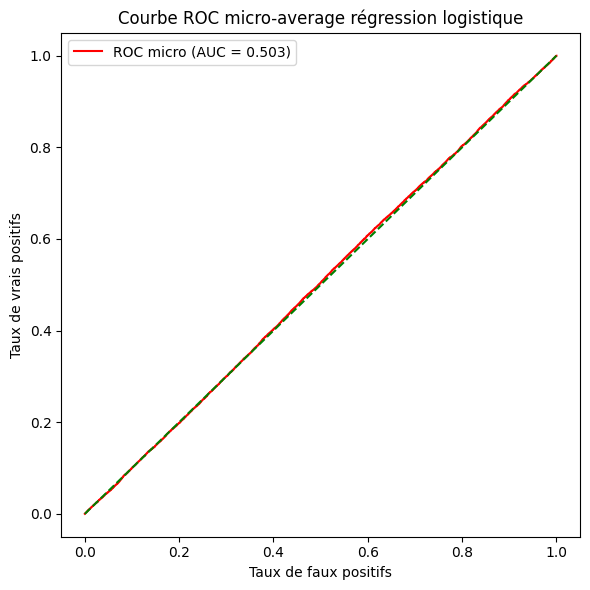

AUC ROC micro : 0.5025354628968314


In [28]:
from sklearn.metrics import roc_curve, auc

Y_scores = model_lr.predict_proba(X_val)
y_true = Y_val.ravel()
y_score = np.array(Y_scores).T.ravel()

fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))

plt.plot(
    fpr,
    tpr,
    color="red",
    label="ROC micro (AUC = {:.3f})".format(roc_auc)
)

plt.plot([0, 1], [0, 1], linestyle="--", color="green")

plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title("Courbe ROC micro-average régression logistique")
plt.legend()
plt.tight_layout()

plt.savefig(os.path.join(RESULTS_DIR, "roc_micro_lr.png"), dpi=200)
plt.show()

print("AUC ROC micro :", roc_auc)

In [30]:
results = []

results.append({
    "Modèle": "Régression logistique",
    "F1 micro": f1_score(Y_val, Y_pred_lr, average="micro", zero_division=0),
    "F1 macro": f1_score(Y_val, Y_pred_lr, average="macro", zero_division=0),
    "Précision micro": precision_score(Y_val, Y_pred_lr, average="micro", zero_division=0),
    "Rappel micro": recall_score(Y_val, Y_pred_lr, average="micro", zero_division=0)
})

results.append({
    "Modèle": "Forêt aléatoire",
    "F1 micro": f1_score(Y_val, Y_pred_rf, average="micro", zero_division=0),
    "F1 macro": f1_score(Y_val, Y_pred_rf, average="macro", zero_division=0),
    "Précision micro": precision_score(Y_val, Y_pred_rf, average="micro", zero_division=0),
    "Rappel micro": recall_score(Y_val, Y_pred_rf, average="micro", zero_division=0)
})

results_df = pd.DataFrame(results)
print(results_df)


                  Modèle  F1 micro  F1 macro  Précision micro  Rappel micro
0  Régression logistique  0.070275  0.050610         0.037188      0.637357
1        Forêt aléatoire  0.582980  0.052901         0.771444      0.468520


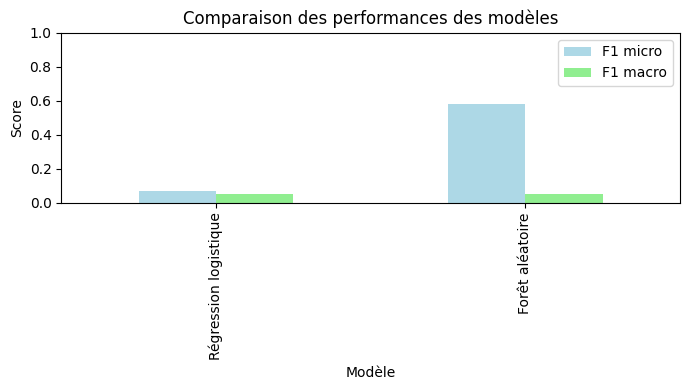

In [31]:
results_df.set_index("Modèle")[["F1 micro", "F1 macro"]].plot(
    kind="bar",
    figsize=(7, 4),
    color=["lightblue", "lightgreen"]
)

plt.title("Comparaison des performances des modèles")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [32]:

import random

print("\nExemples de protéines avec leurs annotations GO :\n")

for pid in random.sample(list(protein_to_go.keys()), 5):
    print("Protéine :", pid)
    print("Termes GO associés :", protein_to_go[pid])



Exemples de protéines avec leurs annotations GO :

Protéine : P0ABB0
Termes GO associés : ['GO:0005515']
Protéine : P76052
Termes GO associés : ['GO:0005515', 'GO:0046982']
Protéine : Q60GF7
Termes GO associés : ['GO:0005515']
Protéine : P39825
Termes GO associés : ['GO:0005085', 'GO:0005515']
Protéine : Q09373
Termes GO associés : ['GO:0005515']
